In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
warnings.filterwarnings(action='ignore')


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)

import sklearn
from sklearn.neighbors import KNeighborsRegressor

from preprocess import *


In [62]:
# load data
time_data = pd.read_csv('data/original/time_data.txt', sep  = ' ') 
time_data = df2npy(time_data)

# 아침 점심 저녁 분리
morning_data = time_data[:,2,:,:]
lunch_data = time_data[:,1,:,:]
evening_data = time_data[:,0,:,:]

# split time data
# train_validation_test
# scaling
# make intput, output window
morning_data, train_valid_test_loc_index, m_time_scaler = split_train_valid_test(morning_data)
lunch_data, _, l_time_scaler = split_train_valid_test(lunch_data)
evening_data, _, e_time_scaler = split_train_valid_test(evening_data)

# split notime data
# notime_train, notime_valid, notime_test = notime
nontime_data = pd.read_csv('data/original/nontime_data.txt', sep = ' ')
notime, no_time_scaler = split_notime_data(nontime_data, train_valid_test_loc_index)

print('\n morning')
m_train_time, m_train_notime, m_train_y = make_time_notime_data(morning_data[0], notime)
m_valid_time, m_valid_notime, m_valid_y = make_time_notime_data(morning_data[1], notime)
m_test_time, m_test_notime, m_test_y = make_time_notime_data(morning_data[2], notime)

print('\n lunch')
l_train_time, l_train_notime, l_train_y = make_time_notime_data(lunch_data[0], notime)
l_valid_time, l_valid_notime, l_valid_y = make_time_notime_data(lunch_data[1], notime)
l_test_time, l_test_notime, l_test_y = make_time_notime_data(lunch_data[2], notime)

print('\n evening')
e_train_time, e_train_notime, e_train_y = make_time_notime_data(evening_data[0], notime)
e_valid_time, e_valid_notime, e_valid_y = make_time_notime_data(evening_data[1], notime)
e_test_time, e_test_notime, e_test_y = make_time_notime_data(evening_data[2], notime)


 morning
(9185, 20, 12)
(9185, 3)
(9185, 7, 2)
(330, 20, 12)
(330, 3)
(330, 7, 2)
(1309, 20, 12)
(1309, 3)
(1309, 7, 2)

 lunch
(9185, 20, 12)
(9185, 3)
(9185, 7, 2)
(330, 20, 12)
(330, 3)
(330, 7, 2)
(1309, 20, 12)
(1309, 3)
(1309, 7, 2)

 evening
(9185, 20, 12)
(9185, 3)
(9185, 7, 2)
(330, 20, 12)
(330, 3)
(330, 7, 2)
(1309, 20, 12)
(1309, 3)
(1309, 7, 2)


In [31]:
class LSTMModel_trend(nn.Module):
    def __init__(self, input_size, hidden_size, no_time_size):
        # time model
        super(LSTMModel_trend, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.time_fc = nn.Linear(hidden_size, 1)
        
        # no time model
        self.no_time_fc = nn.Sequential(
            nn.Linear(no_time_size,8),
            nn.ReLU(inplace=True),
            nn.Linear(8,16),
            nn.ReLU(inplace=True),
            nn.Linear(16,7)
        )
        # merge model
        self.merge_fc = nn.Sequential(
            nn.Linear(14, 7)
        )
    
    def forward(self, x_time, x_no_time):
        # time part
        hidden = (
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device),
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device)
        )
        
        out_time, _ = self.lstm(x_time, hidden)

        out_time = self.time_fc(out_time[:, -7:, :])#
        
        # no_time part
        out_no_time = self.no_time_fc(x_no_time)
        
        # merge part
        out_no_time = out_no_time.view((-1,7,1))
        
        out = torch.cat((out_time, out_no_time), 1)
        
        out = out.view(-1,14)
        #print(out.shape)        
        out = self.merge_fc(out)
        
        return out.view(-1,7)

In [32]:
class LSTMModel_trend(nn.Module):
    def __init__(self, input_size, hidden_size, no_time_size):

        # time model
        super(LSTMModel_trend, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.time_fc = nn.Linear(hidden_size, 1)
        
        # no time model
        self.no_time_fc = nn.Sequential(
            nn.Linear(no_time_size,16),
            nn.ReLU(inplace=True),
            nn.Linear(16,16),
            nn.ReLU(inplace=True),
            nn.Linear(16,8),
            nn.ReLU(inplace=True),
            nn.Linear(8,1)
        )
        
        # merge model
        self.merge_fc = nn.Sequential(
            nn.Linear(7, 14),
            nn.ReLU(inplace=True),
            nn.Linear(14,7)
        )
    

    def forward(self, x_time, x_no_time):
        # time part
        hidden = (
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device),
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device)
        )
        
        out_time, _ = self.lstm(x_time, hidden)
        out_time = self.time_fc(out_time[:, -7:, :])#
        
        # no_time part
        out_no_time = self.no_time_fc(x_no_time)
        
        # merge part
        #out_no_time = out_no_time.view((-1,7,1))
        
        #out = torch.cat((out_time, out_no_time), 1)
        out_no_time = out_no_time.view((-1,1,1))

        out = out_time * out_no_time
        
        out = out.view(-1,7)
        #print(out.shape)        
        out = self.merge_fc(out)
        
        return out.view(-1,7)

In [63]:
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
m_train_time = torch.FloatTensor(m_train_time[:,:,2:]).to(device)
m_train_notime = torch.FloatTensor(m_train_notime).to(device)
m_train_y = torch.FloatTensor(m_train_y).to(device)
 
m_valid_time = torch.FloatTensor(m_valid_time[:,:,2:]).to(device)
m_valid_notime = torch.FloatTensor(m_valid_notime).to(device)
m_valid_y = torch.FloatTensor(m_valid_y).to(device)

In [50]:
# hidden state : 전달과정 중간 출력의 차원
model_trend = LSTMModel_trend(input_size = 10, hidden_size = 32, no_time_size = 3).to(device)
optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

# Train model
#####################
num_epochs  = 500
hist = np.zeros(num_epochs)

# Number of steps to unroll
look_back = 21
seq_dim =look_back - 1  

train_error = []
valid_error = []

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass
    train_trend_pred = model_trend(m_train_time, m_train_notime)
    loss = criterion(train_trend_pred, m_train_y[:,:,0])
    train_error.append(loss)

    valid_trend_pred = model_trend(m_valid_time, m_valid_notime)
    valid_mse = float(criterion(valid_trend_pred, m_valid_y[:,:,0]).cpu())
    valid_error.append(valid_mse)

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

10 Epochs train MSE: 0.46103 // valid MSE: 0.12528
20 Epochs train MSE: 0.06636 // valid MSE: 0.10356
30 Epochs train MSE: 0.02649 // valid MSE: 0.06817
40 Epochs train MSE: 0.01222 // valid MSE: 0.03672
50 Epochs train MSE: 0.00888 // valid MSE: 0.03518
60 Epochs train MSE: 0.00699 // valid MSE: 0.03455
70 Epochs train MSE: 0.00608 // valid MSE: 0.03113
80 Epochs train MSE: 0.00537 // valid MSE: 0.02932
90 Epochs train MSE: 0.00485 // valid MSE: 0.02771
100 Epochs train MSE: 0.00442 // valid MSE: 0.02611
110 Epochs train MSE: 0.00406 // valid MSE: 0.02476
120 Epochs train MSE: 0.00376 // valid MSE: 0.02385
130 Epochs train MSE: 0.00351 // valid MSE: 0.02363
140 Epochs train MSE: 0.00332 // valid MSE: 0.02382
150 Epochs train MSE: 0.00315 // valid MSE: 0.02395
160 Epochs train MSE: 0.00301 // valid MSE: 0.02411
170 Epochs train MSE: 0.00290 // valid MSE: 0.02428
180 Epochs train MSE: 0.00280 // valid MSE: 0.02447
190 Epochs train MSE: 0.00430 // valid MSE: 0.03154
200 Epochs train MSE:

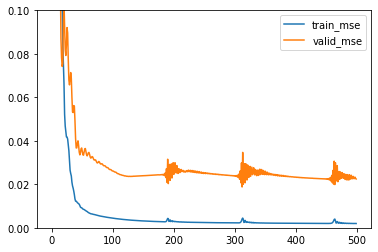

In [51]:
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

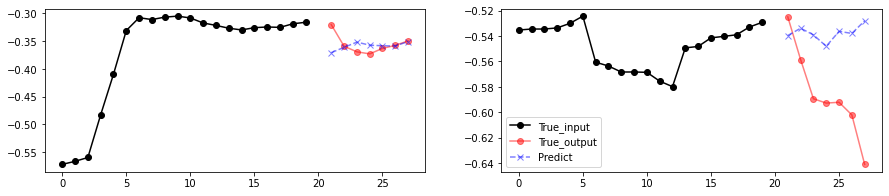

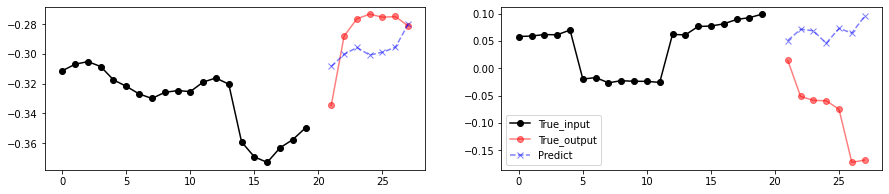

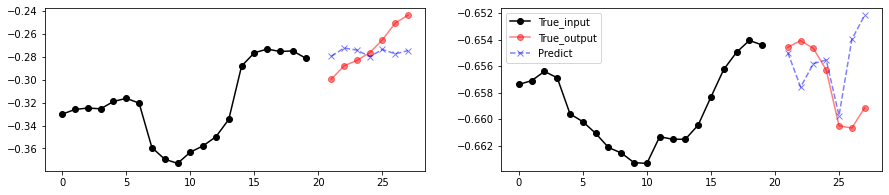

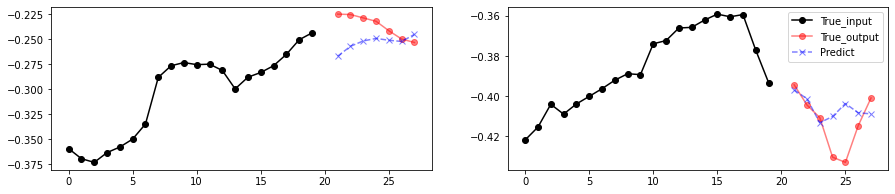

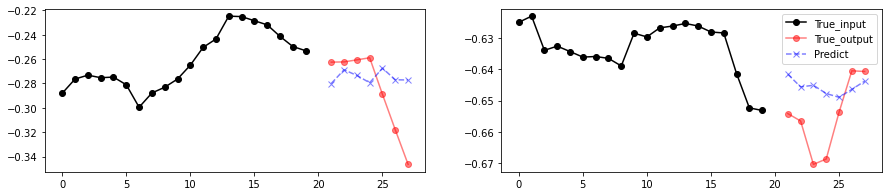

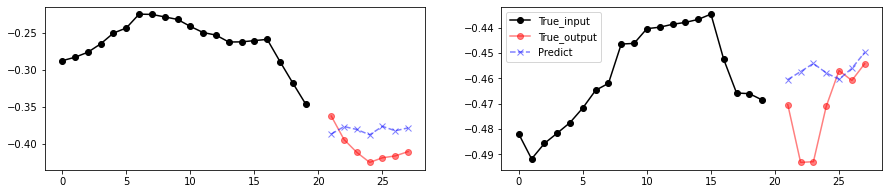

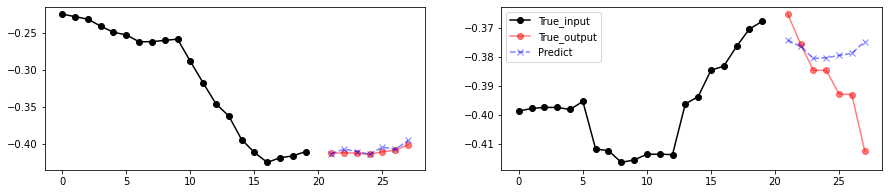

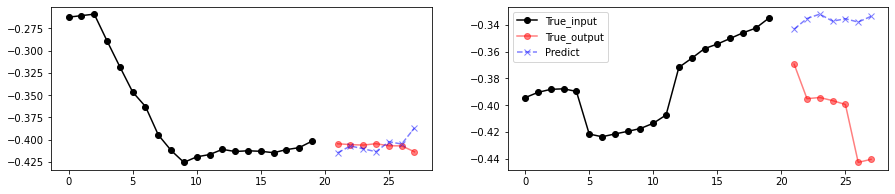

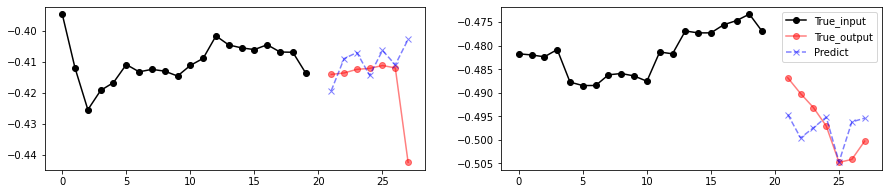

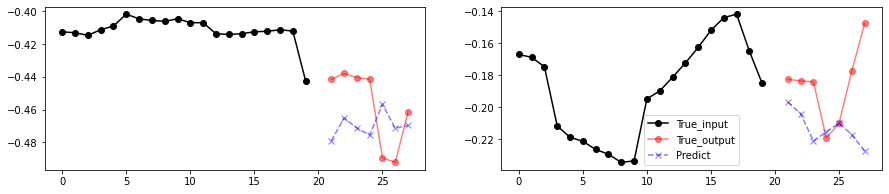

In [52]:
valid_trend_pred = model_trend(m_valid_time, m_valid_notime)

for i in range(10):
    i = i*7
    plt.figure(figsize = (15, 3))
    
    plt.subplot(1,2,1)
    plt.plot(np.arange(20),m_train_time.cpu().detach().numpy()[i,:,-2],
             marker = 'o', color = 'black', label = 'True_input')
    plt.plot(np.arange(21,28),m_train_y[:,:,0].cpu().detach().numpy()[i],
             marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
    plt.plot(np.arange(21,28),train_trend_pred.cpu().detach().numpy()[i],
             color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
    
    plt.subplot(1,2,2)
    plt.plot(np.arange(20),m_valid_time.cpu().detach().numpy()[i,:,-2],
             marker = 'o', color = 'black', label = 'True_input')
    plt.plot(np.arange(21,28),m_valid_y[:,:,0].cpu().detach().numpy()[i],
             marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
    plt.plot(np.arange(21,28),valid_trend_pred.cpu().detach().numpy()[i],
             color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
    
    plt.legend()
    plt.show()

In [72]:
#hidden state : 전달과정 중간 출력의 차원
model_cycle = LSTMModel_trend(input_size = 10, hidden_size = 32, no_time_size = 3).to(device)
optimizer = torch.optim.Adam(model_cycle.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

# Train model
#####################
num_epochs  = 30
hist = np.zeros(num_epochs)

# Number of steps to unroll
look_back = 21
seq_dim =look_back - 1  

train_error = []
valid_error = []

early_stop = 0
patient = 0

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass

    # train error
    train_cycle_pred = model_cycle(m_train_time, m_train_notime)
    loss = criterion(train_cycle_pred, m_train_y[:,:,1])
    train_error.append(loss)
    
    # valid error
    valid_cycle_pred = model_cycle(m_valid_time, m_valid_notime)
    valid_mse = float(criterion(valid_cycle_pred, m_valid_y[:,:,1]).cpu())
    valid_error.append(valid_mse)
    
    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimizer.step()
    
    if t % 4 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

    #early stopping
    if early_stop < valid_mse:
        early_stop = valid_mse
        patient += 1
        if patient == 2:
            break
    else:
        patient = 0
print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

4 Epochs train MSE: 0.18265 // valid MSE: 0.18902
8 Epochs train MSE: 0.17466 // valid MSE: 0.18119
12 Epochs train MSE: 0.16586 // valid MSE: 0.17192
16 Epochs train MSE: 0.13932 // valid MSE: 0.14969
20 Epochs train MSE: 0.09874 // valid MSE: 0.13253
24 Epochs train MSE: 0.07175 // valid MSE: 0.12955
28 Epochs train MSE: 0.05744 // valid MSE: 0.12871
29 Epochs train MSE: 0.05441 // valid MSE: 0.12866


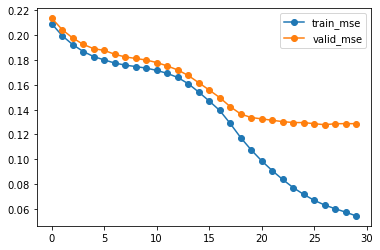

In [75]:
plt.plot(train_error, 'o-', label = 'train_mse')
plt.plot(valid_error, 'o-', label = 'valid_mse')
plt.xticks(label = 'epochs')
plt.legend()
plt.show()

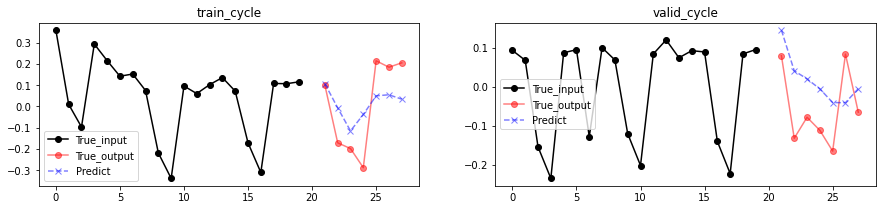

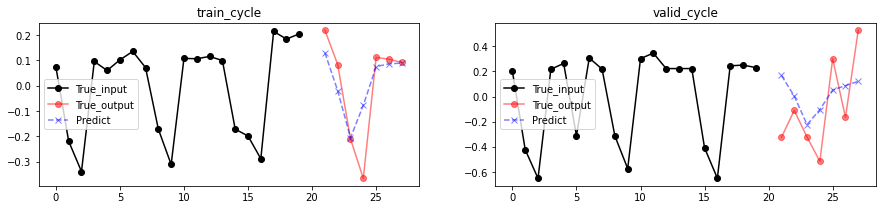

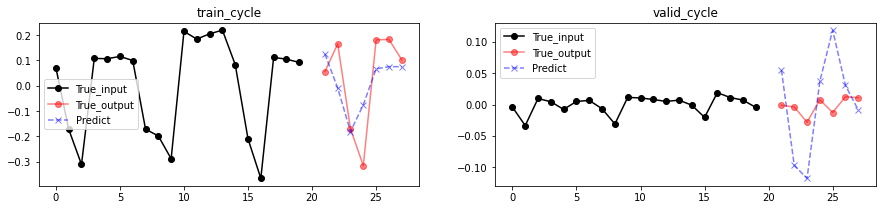

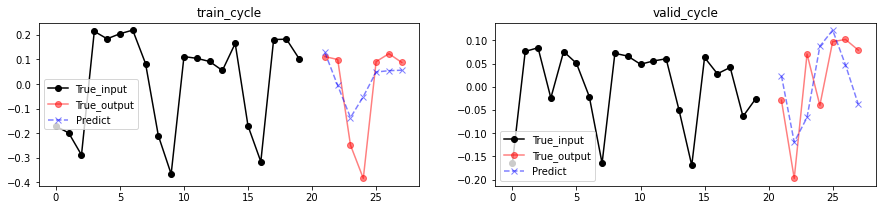

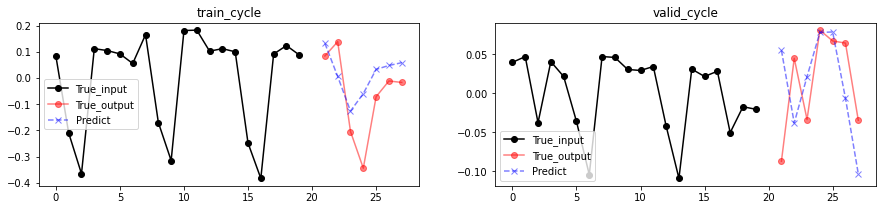

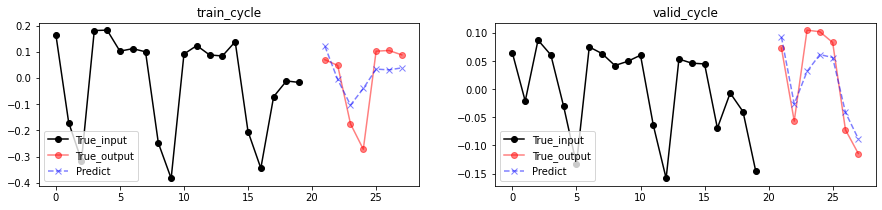

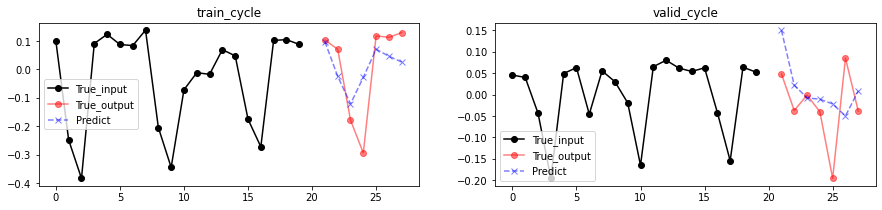

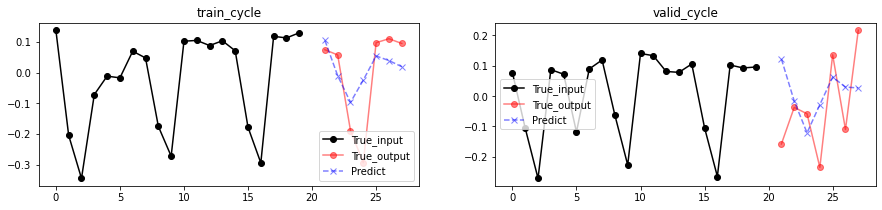

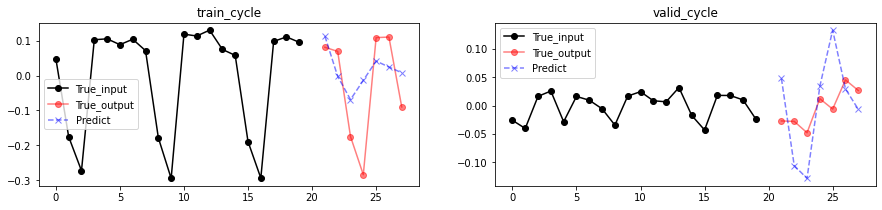

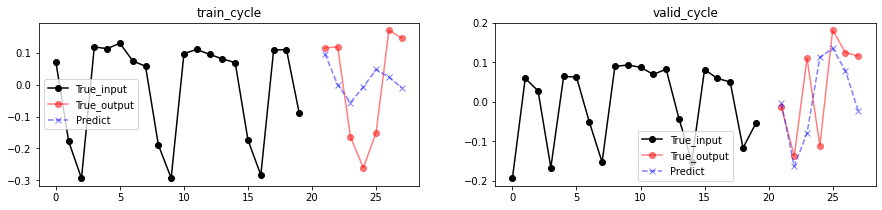

In [77]:
valid_cycle_pred = model_cycle(m_valid_time, m_valid_notime)

for i in range(10):
    i = i*7
    plt.figure(figsize = (15, 3))
    plt.subplot(1,2,1)
    plt.plot(np.arange(20),m_train_time.cpu().detach().numpy()[i,:,-1],
             marker = 'o', color = 'black', label = 'True_input')
    plt.plot(np.arange(21,28),m_train_y[:,:,1].cpu().detach().numpy()[i],
             marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
    plt.plot(np.arange(21,28),train_cycle_pred.cpu().detach().numpy()[i],
             color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
    plt.title('train_cycle')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(20),m_valid_time.cpu().detach().numpy()[i,:,-1],
             marker = 'o', color = 'black', label = 'True_input')
    plt.plot(np.arange(21,28),m_valid_y[:,:,1].cpu().detach().numpy()[i],
             marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
    plt.plot(np.arange(21,28),valid_cycle_pred.cpu().detach().numpy()[i],
             color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
             
    plt.title('valid_cycle')
    plt.legend()
    plt.show()

In [57]:
def plot_result(data_time, data_y, trend_pred, cycle_pred, i, m_time_scaler = m_time_scaler, inverse_scale = False):
    
    trend_input = data_time[i,:,-2]
    cycle_input = data_time[i,:,-1]

    # true output
    trend_output = data_y[:,:,0][i]
    cycle_output = data_y[:,:,1][i]
 
    # pred output
    trend_pred = trend_pred[i]
    cycle_pred = cycle_pred[i]
   
    if inverse_scale == True:
        trend_input = m_time_scaler.inverse_transform(trend_input, select_col = 0)
        cycle_input = m_time_scaler.inverse_transform(cycle_input, select_col = 0)

        trend_output = m_time_scaler.inverse_transform(trend_output, select_col = 0)
        cycle_output = m_time_scaler.inverse_transform(cycle_output, select_col = 0)

        trend_pred = m_time_scaler.inverse_transform(trend_pred, select_col = 0)
        cycle_pred = m_time_scaler.inverse_transform(cycle_pred, select_col = 0)

    total_input = trend_input +  cycle_input
    total_output = trend_output +  cycle_output
    total_pred = trend_pred + cycle_pred
    
    # input
    '''
    plt.plot(np.arange(20), trend_input,# trend
             marker = 'o', color = 'blue', alpha = 0.2)#, label = 'trend_input')
    plt.plot(np.arange(20), cycle_input, # cycle
             marker = 'o', color = 'red', alpha = 0.2)#, label = 'cycle_input')
    '''
    plt.plot(np.arange(20), total_input, # trend + cycle
             marker = 'o', color = 'black')#, label = 'total_input')
    '''
    # true output
    plt.plot(np.arange(21,28), trend_output,# trend
             marker = 'o', color = 'blue', alpha = 0.2)#, label = 'tend_true')
    plt.plot(np.arange(21,28), cycle_output, # cycle
             marker = 'o', color = 'red', alpha = 0.2)#, label = 'cycle_true')
    '''
    plt.plot(np.arange(21,28), total_output, # trend + cycle
             marker = 'o', color = 'black')#, label = 'total_true')
    '''
    # pred output
    plt.plot(np.arange(21,28), trend_pred,# trend
             marker = 'o', color = 'blue', alpha = 0.2, ls = 'dashdot', label = 'trend_pred')
    plt.plot(np.arange(21,28), cycle_pred, # cycle
             marker = 'o', color = 'red', alpha = 0.2, ls = 'dashdot',label = 'cycle_pred')
    '''
    plt.plot(np.arange(21,28), total_pred, # trend + cycle
             marker = 'o', color = 'brown', ls = 'dashdot',label = 'total_pred')

In [54]:
m_train_time = m_train_time.cpu().detach().numpy()
m_train_y = m_train_y.cpu().detach().numpy()
train_trend_pred = train_trend_pred.cpu().detach().numpy()
train_cycle_pred = train_cycle_pred.cpu().detach().numpy()

m_valid_time = m_valid_time.cpu().detach().numpy()
m_valid_y = m_valid_y.cpu().detach().numpy()
valid_trend_pred = valid_trend_pred.cpu().detach().numpy()
valid_cycle_pred = valid_cycle_pred.cpu().detach().numpy()

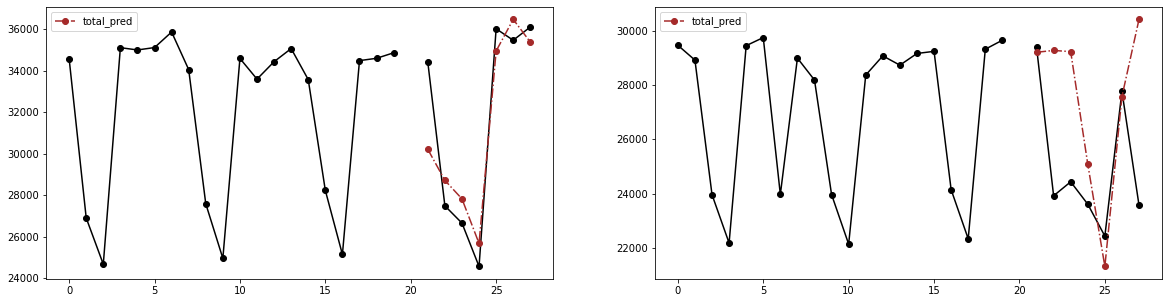

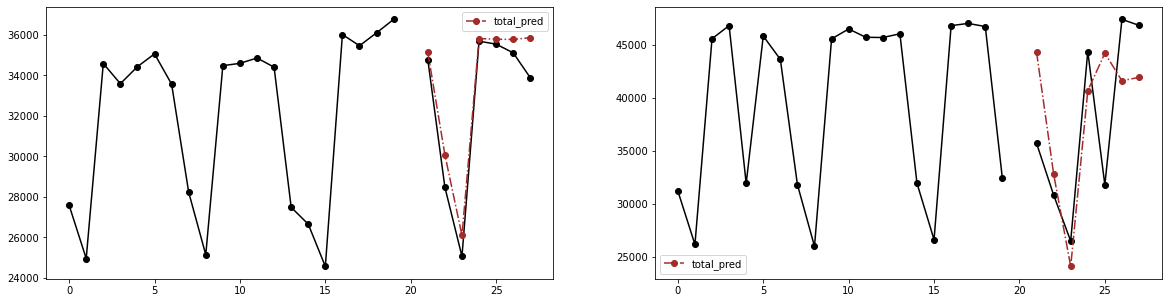

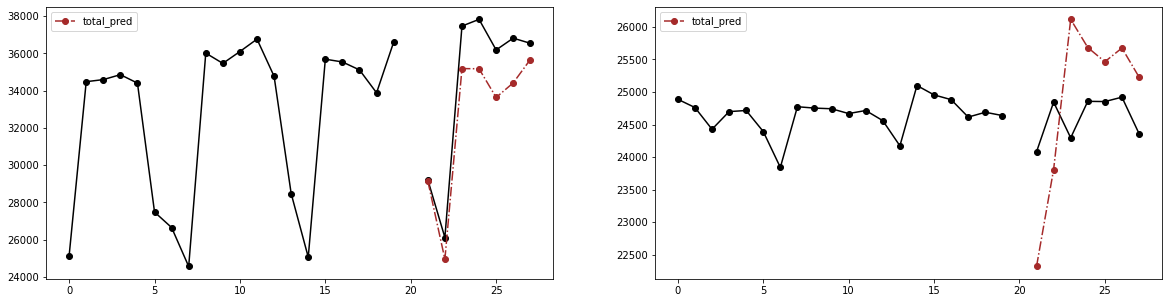

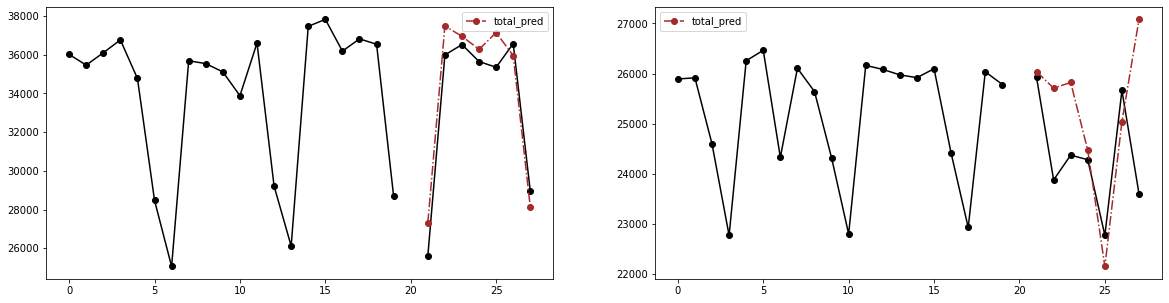

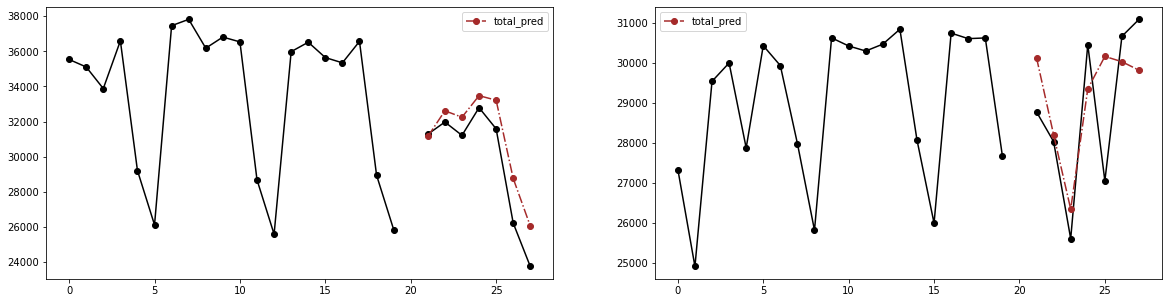

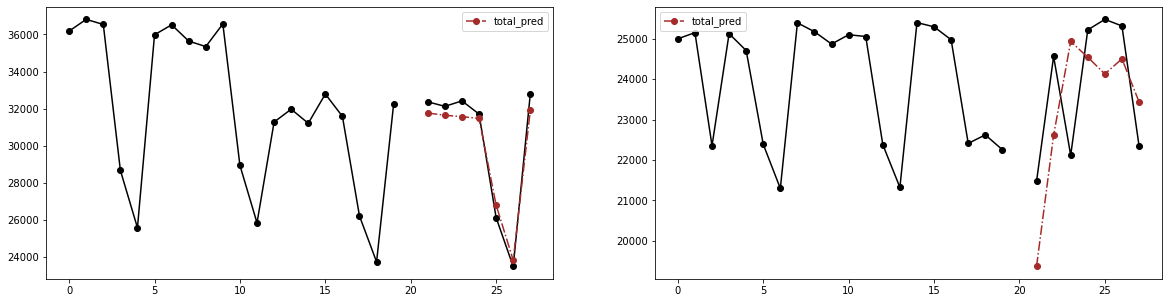

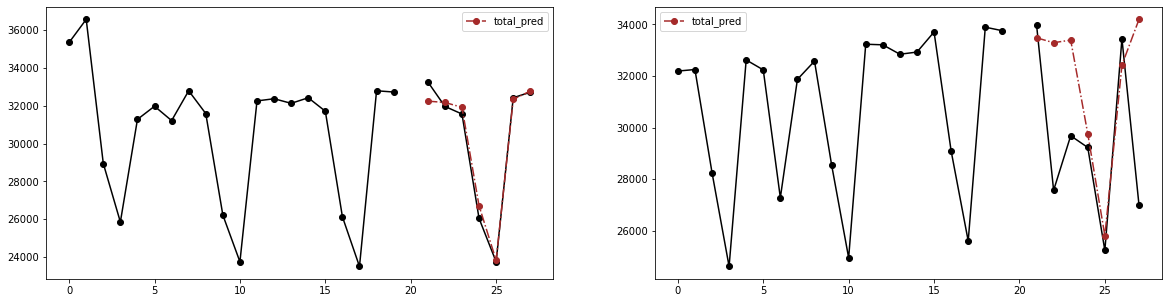

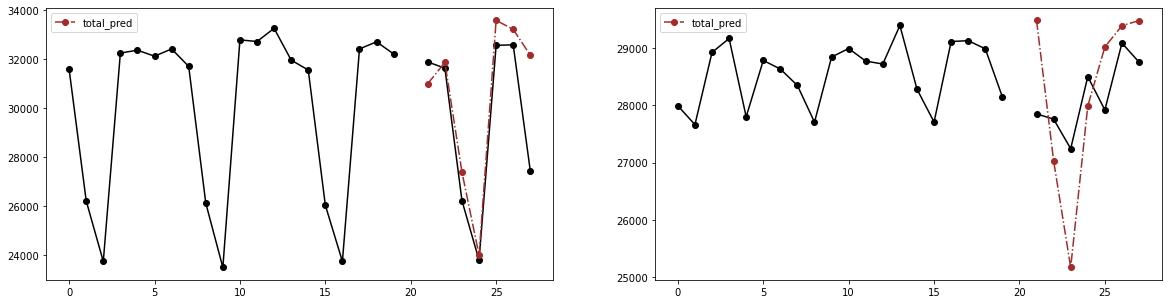

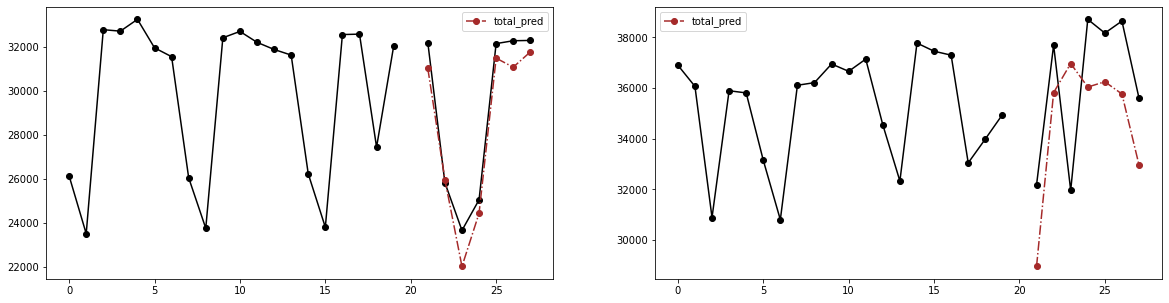

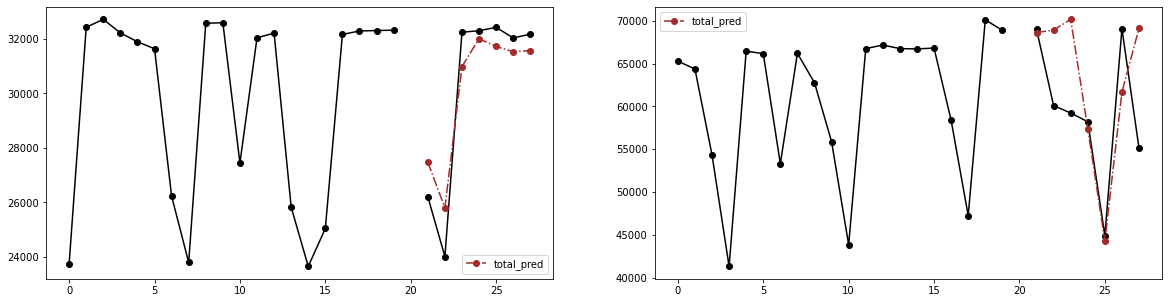

In [59]:
for i in range(10):
    i = i*8
    plt.figure(figsize = (20, 5))
    plt.subplot(1,2,1)
    plot_result(m_train_time, m_train_y, train_trend_pred, train_cycle_pred, i, inverse_scale=True)
    plt.legend()

    plt.subplot(1,2,2)
    plot_result(m_valid_time, m_valid_y, valid_trend_pred, valid_cycle_pred, i, inverse_scale=True)
    plt.legend()
    plt.show()